Since we are running out of memory for our original environment, I thought it was best to redo our whole thing on another jupyter notebook.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import PIL.Image as Image
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt
import os

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
path = Path("/kaggle/input/az-handwritten-alphabets-in-csv-format") # Path to our dataset

In [4]:
df = pd.read_csv('/kaggle/input/handwritten-alphabets/Handwritten Alphabets Data.csv')

In [5]:
df['0'] = [ chr(i+ord('A')) for i in  df['0']]

In [6]:
def tensorify(a):
    return torch.FloatTensor(a)

Here we will change our approach a little. I have already went ahead and built the GAN model and ran it but all the letters kept changing into O's. O's have a lot of influence already and it is simple for the model to make an O instead of a complex shape. Thus, I limited the dataset to have 500 of each letters in data.

In [72]:
train_set, val_set, test_set = [], [], []
for character in tqdm(range(26)):
    arr = np.array(df[df['0'] == chr(character+ord('A'))])[:500,1:] # getting only what corresponds to our letter
    random.shuffle(arr)     # Shuffling our dataset to ensure that our model will work under random circumstance
    arr = arr/256           # We want our data to be between 0 and 1
    arr = arr.reshape(-1, 1, 28, 28)
    
    a = [0]*26
    a[character] = 1        # one hot encoding of data

    # Let's split each part set into 60 - 20 - 20 sets for our train, val, and test set
    train_set.extend([ (tensorify(dt.astype(float)), tensorify(a)) for dt in arr[: int(0.6*len(arr))]] )
    val_set.extend(  [ (tensorify(dt.astype(float)), tensorify(a)) for dt in arr[int(0.6*len(arr)) : int(0.8*len(arr))]] )
    test_set.extend( [ (tensorify(dt.astype(float)), tensorify(a)) for dt in arr[int(0.8*len(arr)) :]] )

100%|██████████| 26/26 [00:17<00:00,  1.50it/s]


In [73]:
random.shuffle(train_set)    # Basic shuffling to ensure randomness and that the data isn't fed from A to Z in order
random.shuffle(val_set)
random.shuffle(test_set)

In [74]:
train_dataloader = DataLoader(dataset = train_set, batch_size = 64, num_workers = 2)
val_dataloader = DataLoader(dataset = val_set, batch_size = 64, num_workers = 2)
test_dataloader = DataLoader(dataset = test_set, batch_size = 64, num_workers = 2)

# **TASK 2**

**Part 2**

Now that we've made out dataset again, we will now make our GAN architecture with a generator and discriminator.

Below is our generator, which creates a 28 by 28 image from 100 tensor values.

In [75]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
def make_generator_model():
    model = nn.Sequential()
    model.append(nn.Linear(100, 7*7*256))
    model.append(nn.LeakyReLU())
    model.append(Reshape(-1, 256,7,7))
    model.append(nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False))
    model.append(nn.BatchNorm2d(128))
    model.append(nn.LeakyReLU())
    model.append(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False))
    model.append(nn.BatchNorm2d(64))
    model.append(nn.LeakyReLU())
    model.append(nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False))
    model.append(nn.Tanh())

    return model

In [76]:
gen = make_generator_model().to(DEVICE)

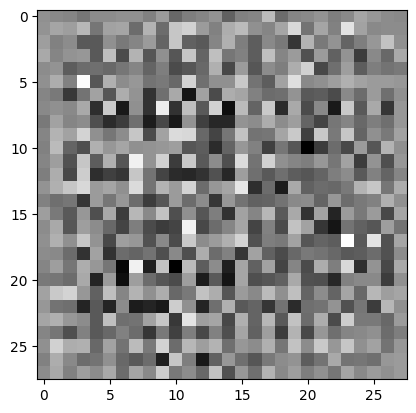

In [77]:
gen.eval()
noise = torch.randn(1,100)
generated_img = gen(noise.to(DEVICE))

plt.imshow((generated_img[0][0].detach().cpu().numpy()*127.5+127.5).astype(int), cmap='gray')

Our discriminator creates an output from a 28 by 28 image.

In [91]:
def make_discriminator_model():
    model = nn.Sequential()
    model.append(nn.Conv2d(1, 64, kernel_size = 5, stride = 2, padding = 2))
    model.append(nn.LeakyReLU())
    model.append(nn.Dropout(0.3))
    model.append(nn.Conv2d(64, 128, kernel_size = 5, stride = 2, padding = 2))
    model.append(nn.LeakyReLU())
    model.append(nn.Dropout(0.3))
    model.append(nn.Flatten(-3))
    model.append(nn.Linear(128*7*7, 1))

    return model

In [79]:
disc = make_discriminator_model().to(DEVICE)

Let's use binary cross entropy loss.

In [92]:
criterion = nn.BCEWithLogitsLoss()

In [81]:
def generator_loss(fake_output):
    return criterion(torch.ones(fake_output.shape).to(DEVICE), fake_output)

In [82]:
def discriminator_loss(output, label):
    return criterion(output, label)

In [83]:
g_optimizer = optim.Adam(gen.parameters(), 1e-3)
d_optimizer = optim.Adam(disc.parameters(), 1e-3)

In [86]:
def generate_images(model, epoch, test_input):
    model.eval()
    predictions = model(test_input)
    fig = plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i][0].detach().cpu().numpy()*127.5+127.5).astype(int), cmap='gray')
        plt.axis('off')
    plt.show()

100%|██████████| 122/122 [00:01<00:00, 69.67it/s]


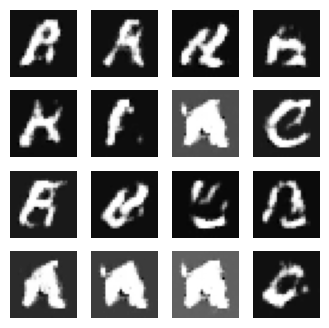

100%|██████████| 122/122 [00:01<00:00, 68.57it/s]


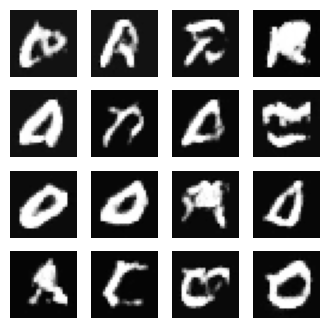

100%|██████████| 122/122 [00:01<00:00, 71.57it/s]


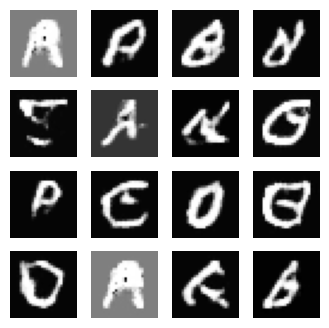

100%|██████████| 122/122 [00:01<00:00, 71.78it/s]


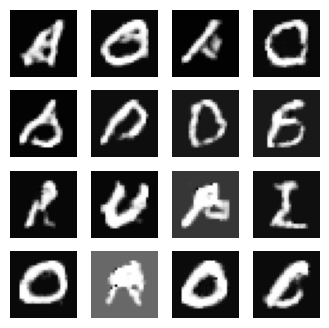

100%|██████████| 122/122 [00:01<00:00, 70.50it/s]


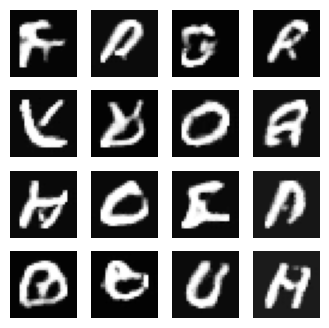

100%|██████████| 122/122 [00:01<00:00, 70.47it/s]


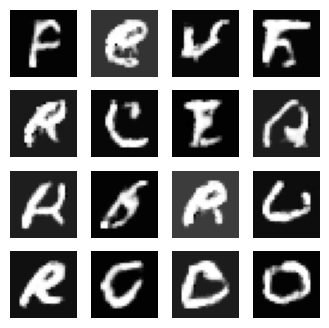

100%|██████████| 122/122 [00:01<00:00, 70.24it/s]


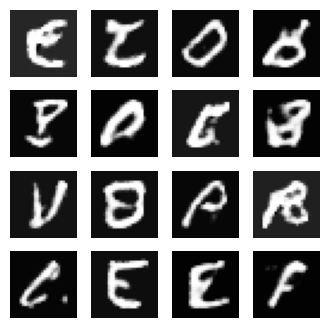

100%|██████████| 122/122 [00:01<00:00, 70.97it/s]


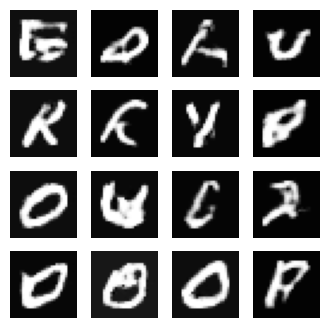

100%|██████████| 122/122 [00:01<00:00, 66.27it/s]


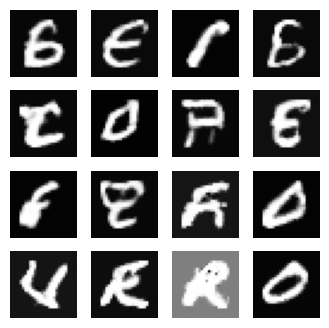

100%|██████████| 122/122 [00:01<00:00, 71.50it/s]


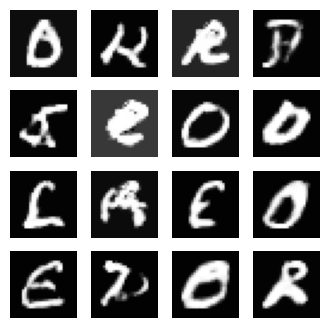

In [89]:
for epoch in range(100):     #We give it a good 100 epochs
    gen.train()
    disc.train()
    for batch, lbl in tqdm(train_dataloader):
        d_optimizer.zero_grad()
        
        noise = torch.randn(batch.shape[0], 100)
        
        generated_img = gen(noise.to(DEVICE))
        fake_output = disc(generated_img)  
        disc_loss1 = discriminator_loss(fake_output, torch.zeros(fake_output.shape).to(DEVICE))
        
        real_output = disc(batch.to(DEVICE))
        disc_loss2 = discriminator_loss(real_output, torch.ones(real_output.shape).to(DEVICE))
        
        disc_loss = (disc_loss1 + disc_loss2)/2
        disc_loss.backward()
        
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        
        generated_img = gen(noise.to(DEVICE))
        fake_output = disc(generated_img) 
        gen_loss = generator_loss(fake_output)
        gen_loss.backward()
        
        g_optimizer.step()
        
    if (epoch+1)%10 == 0:
        generate_images(gen, epoch+1, noise.to(DEVICE))

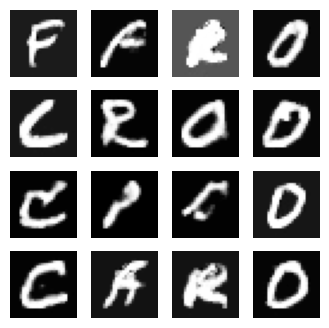

In [90]:
seed = torch.randn((16, 100))

generate_images(gen, epoch+1, seed.to(DEVICE))

As we can see, our GAN model makes pretty good images of what we can verifiably see are letters, or something close to them. There are still a lot of O representation but that is passable.